In [1]:
import streamlit as st
import jsonlines
import random
import pandas as pd
import seaborn as sns
import json
import fileinput
import numpy as np
import nltk
from pprint import pprint
from wordcloud import WordCloud
from textblob_de import TextBlobDE as TextBlob
import re
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from datetime import date
import re
import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2022-06-10 15:24:41.330 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [2]:
#Importing Dataset
olafScholzJsonLines = jsonlines.open("OlafScholz.jl")

olafScholzTwitter = pd.read_json("OlafScholz.jl", lines = True)
print("Datensatzlänge: " + str(olafScholzTwitter.info()))

print(olafScholzTwitter.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   http_status   65 non-null     int64 
 1   account_name  65 non-null     object
 2   account_data  65 non-null     object
 3   params        65 non-null     object
 4   response      65 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.7+ KB
Datensatzlänge: None
   http_status account_name  \
0          200   OlafScholz   
1          200   OlafScholz   
2          200   OlafScholz   
3          200   OlafScholz   
4          200   OlafScholz   

                                        account_data  \
0  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
1  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
2  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
3  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   
4  {'Name': 'Scholz, Olaf', 'Partei': 'SPD', 'id'...   

         

In [3]:
# Reply Dataframe
# Importing Data into final Dataframe for ML
replyDataFrame = pd.DataFrame(columns = ["tweetid", "date", "time", "user", "text"])
print(replyDataFrame.head())
iterator = 0

for line in olafScholzJsonLines:
    keyResponse = line["response"]
    data = keyResponse["data"]
    newDataRow = [None, None, None, None, None]
    userName = line["account_name"]
    newDataRow[4] = userName
    keyResponse = line["response"]
    data = keyResponse["data"]


    for tweet in data:

        tweetTarget = 1
       
        tweetID = tweet["id"]
        authorID = tweet["author_id"]
        tweetDate = tweet["created_at"][0:10]
        tweetTime = tweet["created_at"][11:19]
        tweetText = tweet["text"]        
        newDataRow[0] = tweetID
        newDataRow[1] = tweetDate
        newDataRow[2] = tweetTime
        newDataRow[3] = authorID
        newDataRow[4] = tweetText
        replyDataFrame.loc[len(replyDataFrame)] = newDataRow
    iterator += 1


Empty DataFrame
Columns: [tweetid, date, time, user, text]
Index: []


In [4]:
#print(dir(replyDataFrame))
print(len(replyDataFrame))
print(replyDataFrame.shape)
print(replyDataFrame.head())

6419
(6419, 5)
               tweetid        date      time      user  \
0  1515588838562971650  2022-04-17  07:11:52  38150247   
1  1514644785818058757  2022-04-14  16:40:32  38150247   
2  1514291545742184451  2022-04-13  17:16:53  38150247   
3  1514256817613905929  2022-04-13  14:58:53  38150247   
4  1513955069867274245  2022-04-12  18:59:51  38150247   

                                                text  
0  RT @Bundeskanzler: Ich wünsche Ihnen und Ihren...  
1  RT @Bundeskanzler: Meine Solidarität gilt @Kar...  
2  RT @Bundeskanzler: Sie haben Hilfe organisiert...  
3  RT @Bundeskanzler: Verantwortung übernehmen he...  
4  RT @Bundeskanzler: Die Sanktionen gegen #Russl...  


In [5]:
print("----")
print(replyDataFrame[replyDataFrame["text"].str.contains("RT @Bundeskanzler:")].sort_values("date",ascending = "true").head())

----
                tweetid        date      time      user  \
53  1493195813245313024  2022-02-14  12:09:58  38150247   
52  1493599012691365903  2022-02-15  14:52:09  38150247   
51  1493602211829587986  2022-02-15  15:04:51  38150247   
50  1494003008283287560  2022-02-16  17:37:29  38150247   
49  1494245849085493251  2022-02-17  09:42:26  38150247   

                                                 text  
53  RT @Bundeskanzler: Auf dem Weg in die #Ukraine...  
52  RT @Bundeskanzler: Der Frieden und die Sicherh...  
51  RT @Bundeskanzler: Ich habe Präsident #Putin i...  
50  RT @Bundeskanzler: Die #Corona-Regeln zeigen d...  
49  RT @Bundeskanzler: Gestern Abend habe ich mit ...  


In [6]:
#testing
print(replyDataFrame["text"].str.contains("RT @Bundeskanzler").head())
print(replyDataFrame["text"].str.contains("RT @Bundeskanzler").count())

0    True
1    True
2    True
3    True
4    True
Name: text, dtype: bool
6419


In [7]:
#cleansedTweetDF = replyDataFrame[replyDataFrame["text"].str.contains("RT @Bundeskanzler:") or replyDataFrame["text"].str.contains("!RT @") ]
print("Size of dataframe :\n"+ str(replyDataFrame.count())+"\n----")
maskBundesKanz = replyDataFrame["text"].str.contains("RT @Bundeskanzler:")
maskNoRT = replyDataFrame["text"].str.contains("RT @")==False
print("Size of dataframe with RT @Bundeskanzler:\n" + str(replyDataFrame[maskBundesKanz].count())+"\n----")
print("Size of dataframe without RT @:\n" + str(replyDataFrame[maskNoRT].count())+"\n----")
#cleansedTweetDF contains all Tweets posted directly by Olaf before or after being Kanzler
cleansedTweetDF = replyDataFrame[maskBundesKanz | maskNoRT]
print("Size of cleansedTweetDF @:\n" + str(cleansedTweetDF.count())+"\n----")
print(cleansedTweetDF.head())
#cleansedTweetDF has "RT @Bundeskanzler:" still in the tweet. To not have any issues with ML we removed that part of the Tweet in the following parts

Size of dataframe :
tweetid    6419
date       6419
time       6419
user       6419
text       6419
dtype: int64
----
Size of dataframe with RT @Bundeskanzler:
tweetid    48
date       48
time       48
user       48
text       48
dtype: int64
----
Size of dataframe without RT @:
tweetid    4071
date       4071
time       4071
user       4071
text       4071
dtype: int64
----
Size of cleansedTweetDF @:
tweetid    4119
date       4119
time       4119
user       4119
text       4119
dtype: int64
----
               tweetid        date      time      user  \
0  1515588838562971650  2022-04-17  07:11:52  38150247   
1  1514644785818058757  2022-04-14  16:40:32  38150247   
2  1514291545742184451  2022-04-13  17:16:53  38150247   
3  1514256817613905929  2022-04-13  14:58:53  38150247   
4  1513955069867274245  2022-04-12  18:59:51  38150247   

                                                text  
0  RT @Bundeskanzler: Ich wünsche Ihnen und Ihren...  
1  RT @Bundeskanzler: Meine Solidaritä

In [8]:
# Removing the Text \"RT @Bundeskanzler:\" from the text\n
print("ReplyDataframe: \n" + str(replyDataFrame[maskBundesKanz].count()))
cleansedAtBundKanzDF = replyDataFrame[maskBundesKanz].copy()
cleansedAtBundKanzDF.text = cleansedAtBundKanzDF.text.str.strip("RT @Bundeskanzler: ")
print(cleansedAtBundKanzDF.head())                                                           

ReplyDataframe: 
tweetid    48
date       48
time       48
user       48
text       48
dtype: int64
               tweetid        date      time      user  \
0  1515588838562971650  2022-04-17  07:11:52  38150247   
1  1514644785818058757  2022-04-14  16:40:32  38150247   
2  1514291545742184451  2022-04-13  17:16:53  38150247   
3  1514256817613905929  2022-04-13  14:58:53  38150247   
4  1513955069867274245  2022-04-12  18:59:51  38150247   

                                                text  
0  Ich wünsche Ihnen und Ihren Familien frohe #Os...  
1  Meine Solidarität gilt @Karl_Lauterbach: Jeder...  
2  Sie haben Hilfe organisiert, Kräfte gebündelt ...  
3  Verantwortung übernehmen heißt: Deutschland li...  
4  Die Sanktionen gegen #Russland sind notwendig ...  


In [9]:
#appending the sliced versions to the Dataframe and resulting in the expected 4119 Tweets
cleansedTweetDFShort = replyDataFrame[maskNoRT].append(cleansedAtBundKanzDF)
print(cleansedTweetDFShort.count())
print(cleansedTweetDFShort.sort_values("date",ascending = False).head())

tweetid    4119
date       4119
time       4119
user       4119
text       4119
dtype: int64
               tweetid        date      time      user  \
0  1515588838562971650  2022-04-17  07:11:52  38150247   
1  1514644785818058757  2022-04-14  16:40:32  38150247   
2  1514291545742184451  2022-04-13  17:16:53  38150247   
3  1514256817613905929  2022-04-13  14:58:53  38150247   
4  1513955069867274245  2022-04-12  18:59:51  38150247   

                                                text  
0  Ich wünsche Ihnen und Ihren Familien frohe #Os...  
1  Meine Solidarität gilt @Karl_Lauterbach: Jeder...  
2  Sie haben Hilfe organisiert, Kräfte gebündelt ...  
3  Verantwortung übernehmen heißt: Deutschland li...  
4  Die Sanktionen gegen #Russland sind notwendig ...  


In [10]:
# Tobias 29.05.22 and 30.05.22

# Starting preparing for machine learning

# Making statement text in lower case

cleansedTweetDFShort

#Copy for emotion analysis

def clean(text):
    cleansedTweetDFShort['text'] = cleansedTweetDFShort['text'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
    text = re.sub(r'@[A-Za-z0-9]+\s?', '', text) #Removed Mentions
    text = re.sub(r'#', '', text) #Removed #
    text = re.sub(r'(.)1+', r'1', text) #cleaned single letters
    text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text) #Removes links
    text = re.sub('@','',text) #Remove @
    text = re.sub('ä','ae',text) #Remove ä
    text = re.sub('Ä','Ae',text) #Remove Ä
    text = re.sub('ö','oe',text) #Remove Ä
    text = re.sub('Ö','Oe',text) #Remove Ä
    text = re.sub('ü','ue',text) #Remove Ä
    text = re.sub('Ü','Ue',text) #Remove Ä
    return text

cleansedTweetDFShort['text'] = cleansedTweetDFShort['text'].apply(clean)

cleansedTweetDFShort

,tweetid,date,time,user,text
12,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarlaenderinnen und Saarlaender haben sic...
21,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persoenliche Position ist laengst bekann...
54,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1492074452796022791,2022-02-11,09:54:05,38150247,Fuer die aktuelle Welle der Pandemie gibt es A...
56,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...
...,...,...,...,...,...
49,1494245849085493251,2022-02-17,09:42:26,38150247,Gestern Abend habe ich mit Biden zur Situation...
50,1494003008283287560,2022-02-16,17:37:29,38150247,Die Corona-Regeln zeigen die erhoffte Wirkung....
51,1493602211829587986,2022-02-15,15:04:51,38150247,Ich habe Praesident Putin in Moskau verdeutlic...
52,1493599012691365903,2022-02-15,14:52:09,38150247,Der Frieden und die Sicherheit in Europa sind ...


In [11]:
cleansedTweetDFShort = cleansedTweetDFShort.astype({'text':'string'})
print(cleansedTweetDFShort.dtypes)
cleansedTweetDFShort.head()

tweetid    object
date       object
time       object
user       object
text       string
dtype: object


,tweetid,date,time,user,text
12,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarlaenderinnen und Saarlaender haben sic...
21,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persoenliche Position ist laengst bekann...
54,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1492074452796022791,2022-02-11,09:54:05,38150247,Fuer die aktuelle Welle der Pandemie gibt es A...
56,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...


In [12]:
# Extra DF for wordcloud

cleansedTweetDFShort10 = cleansedTweetDFShort[:100].copy()
cleansedTweetDFShort10

,tweetid,date,time,user,text
12,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarlaenderinnen und Saarlaender haben sic...
21,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persoenliche Position ist laengst bekann...
54,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1492074452796022791,2022-02-11,09:54:05,38150247,Fuer die aktuelle Welle der Pandemie gibt es A...
56,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...
...,...,...,...,...,...
169,1456191852026159105,2021-11-04,09:29:26,38150247,Heute jaehrt sich das Auffliegen des rechtsext...
172,1454008788638474240,2021-10-29,08:54:44,38150247,"Lieber Norbert, vielen Dank fuer das große Eng..."
174,1453697312149151747,2021-10-28,12:17:02,38150247,In der Bundesregierung und auch auf anderen Eb...
176,1453279700990763012,2021-10-27,08:37:36,38150247,"Vielen Dank fuer die Einladung zum Kongress, u..."


In [13]:
#Get Polarity and Subjectivity

# Subjectivity quantifies the amount of personal opinion and factual information contained in the text. 
# The higher subjectivity means that the text contains personal opinion rather than factual information. 
# 0 means low personal opinion and 1 a lot of personal opinion

# If this code failes due to missing download, uncomment following line
# nltk.download("punkt")

def getS (text):
    return TextBlob(text).sentiment.subjectivity

# Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment.

def getP (text):
    return TextBlob(text).sentiment.polarity


cleansedTweetDFShort10['Personal Opinion (Subjectivity)'] = cleansedTweetDFShort10['text'].apply(getS)
cleansedTweetDFShort10['Sentiment (Polarity)'] = cleansedTweetDFShort10['text'].apply(getP)

cleansedTweetDFShort10

,tweetid,date,time,user,text,Personal Opinion (Subjectivity),Sentiment (Polarity)
12,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarlaenderinnen und Saarlaender haben sic...,0.000000,0.675000
21,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persoenliche Position ist laengst bekann...,0.000000,0.175000
54,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",0.000000,0.333333
55,1492074452796022791,2022-02-11,09:54:05,38150247,Fuer die aktuelle Welle der Pandemie gibt es A...,0.000000,0.500000
56,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...,0.000000,0.350000
...,...,...,...,...,...,...,...
169,1456191852026159105,2021-11-04,09:29:26,38150247,Heute jaehrt sich das Auffliegen des rechtsext...,0.000000,-0.037500
172,1454008788638474240,2021-10-29,08:54:44,38150247,"Lieber Norbert, vielen Dank fuer das große Eng...",0.250000,0.175000
174,1453697312149151747,2021-10-28,12:17:02,38150247,In der Bundesregierung und auch auf anderen Eb...,0.250000,0.000000
176,1453279700990763012,2021-10-27,08:37:36,38150247,"Vielen Dank fuer die Einladung zum Kongress, u...",0.333333,0.333333


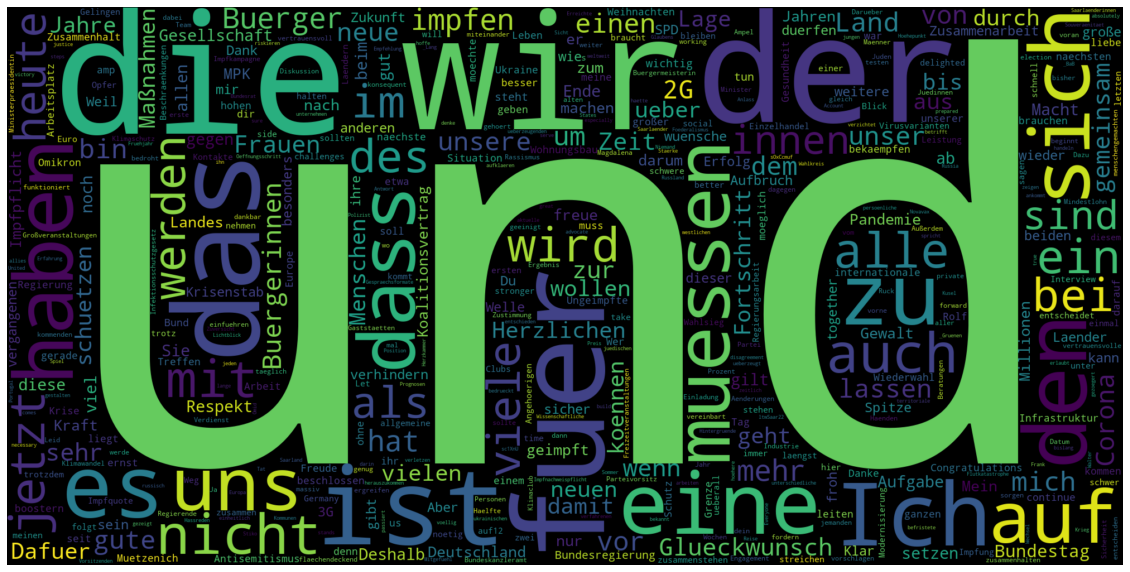

In [14]:
# Plot Word Cloud not cleaned

plt.figure(figsize = (20,20))

allWords = ' '.join([txt for txt in cleansedTweetDFShort10['text']])
wordCloud = WordCloud(max_words=500, width=2000, height = 1000, 
                      max_font_size = 1000, collocations=False).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [15]:
# Defining set containing all stopwords in German. (Stopwords: Word with no relevance for analysis)
# Source for Stopwordlist: https://github.com/stopwords-iso/stopwords-de/blob/master/stopwords-de.json
# Cleaning text from stopwords

# Create copy to work with
cleansedTweetDFShort10copy = cleansedTweetDFShort10.copy()

# Making statement text in lower case
cleansedTweetDFShort10copy['text']=cleansedTweetDFShort10copy['text'].str.lower()

with open('stopwords-de.json','r') as file:
    stopwordlistgerman = json.load(file)

STOPWORDS = set(stopwordlistgerman)

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

cleansedTweetDFShort10copy['text'] = cleansedTweetDFShort10copy['text'].apply(lambda text: cleaning_stopwords(text))
cleansedTweetDFShort10copy['text'].head(10)

12    saarlaenderinnen saarlaender klar fuer wechsel...
21    persoenliche position laengst bekannt: fuer ze...
54    freue mich, folgt - fuer alles, regierungsarbe...
55    fuer aktuelle welle pandemie anlass zuversicht...
56    corona-pandemie flutkatastrophe sommer gezeigt...
57    everyone can be absolutely sure that germany s...
60    staerke westlichen antwort lage russisch-ukrai...
61    muessen verhindern, welle naechste folgt, viru...
62    lage grenze ukraine ernst. klar ist: territori...
64    kusel passiert ist, bedrueckt sehr. mitgefuehl...
Name: text, dtype: object

In [16]:
# Cleaning text from stopwords from nltk.corpus
# If this code failes due to missing download, uncomment following line
#nltk.download('stopwords')

from nltk.corpus import stopwords

STOPLISTnltk = set(stopwords.words('german'))

def clean_tweet(text):
    return " ".join([word for word in str(text).split() if word not in STOPLISTnltk])

cleansedTweetDFShort10copy['text'] = cleansedTweetDFShort10copy['text'].apply(lambda text: clean_tweet(text))
cleansedTweetDFShort10copy.head(10)

,tweetid,date,time,user,text,Personal Opinion (Subjectivity),Sentiment (Polarity)
12,1508125473842335749,2022-03-27,16:55:07,38150247,saarlaenderinnen saarlaender klar fuer wechsel...,0.000000,0.675000
21,1504398354565976070,2022-03-17,10:04:52,38150247,persoenliche position laengst bekannt: fuer ze...,0.000000,0.175000
54,1492872048120668161,2022-02-13,14:43:27,38150247,"freue mich, folgt - fuer alles, regierungsarbe...",0.000000,0.333333
55,1492074452796022791,2022-02-11,09:54:05,38150247,fuer aktuelle welle pandemie anlass zuversicht...,0.000000,0.500000
56,1492074451432873985,2022-02-11,09:54:05,38150247,corona-pandemie flutkatastrophe sommer gezeigt...,0.000000,0.350000
57,1490966801844674560,2022-02-08,08:32:41,38150247,everyone can be absolutely sure that germany s...,0.000000,0.000000
60,1490374584448733191,2022-02-06,17:19:25,38150247,staerke westlichen antwort lage russisch-ukrai...,0.000000,-0.333333
61,1489271202447302661,2022-02-03,16:14:58,38150247,"muessen verhindern, welle naechste folgt, viru...",0.166667,-0.216667
62,1488986727804981251,2022-02-02,21:24:34,38150247,lage grenze ukraine ernst. klar ist: territori...,0.000000,0.000000
64,1488207056234553354,2022-01-31,17:46:26,38150247,"kusel passiert ist, bedrueckt sehr. mitgefuehl...",0.250000,0.175000


In [17]:
# Cleaning text from english stopwords
# Source for Stopwordlist: https://countwordsfree.com/stopwords
# Cleaning text from stopwords
with open('stop_words_english.json','r',encoding='utf-8') as file:
    stopwordlistenglish = json.load(file)

STOPWORDS = set(stopwordlistenglish)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
cleansedTweetDFShort10copy['text'] = cleansedTweetDFShort10copy['text'].apply(lambda text: cleaning_stopwords(text))
cleansedTweetDFShort10copy['text'].head(10)

12    saarlaenderinnen saarlaender klar fuer wechsel...
21    persoenliche position laengst bekannt: fuer ze...
54    freue mich, folgt - fuer alles, regierungsarbe...
55    fuer aktuelle welle pandemie anlass zuversicht...
56    corona-pandemie flutkatastrophe sommer gezeigt...
57    absolutely germany stands allies united russia...
60    staerke westlichen antwort lage russisch-ukrai...
61    muessen verhindern, welle naechste folgt, viru...
62    lage grenze ukraine ernst. klar ist: territori...
64    kusel passiert ist, bedrueckt sehr. mitgefuehl...
Name: text, dtype: object

In [19]:
#Remove punctations

#import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
cleansedTweetDFShort10copy['text']= cleansedTweetDFShort10copy['text'].apply(lambda x: cleaning_punctuations(x))
cleansedTweetDFShort10copy['text'].head(10)

12    saarlaenderinnen saarlaender klar fuer wechsel...
21    persoenliche position laengst bekannt fuer zei...
54    freue mich folgt  fuer alles regierungsarbeit ...
55    fuer aktuelle welle pandemie anlass zuversicht...
56    coronapandemie flutkatastrophe sommer gezeigt ...
57    absolutely germany stands allies united russia...
60    staerke westlichen antwort lage russischukrain...
61    muessen verhindern welle naechste folgt virusv...
62    lage grenze ukraine ernst klar ist territorial...
64    kusel passiert ist bedrueckt sehr mitgefuehl g...
Name: text, dtype: object

In [20]:
# Applying Stemming

from nltk.stem import PorterStemmer
 
porter = PorterStemmer()

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
cleansedTweetDFShort10copy['text']= cleansedTweetDFShort10copy['text'].apply(lambda x: stemming_on_text(x))
cleansedTweetDFShort10copy = cleansedTweetDFShort10copy.astype({'text':'string'})
cleansedTweetDFShort10copy['text'].head()

12    saarlaenderinnen saarlaender klar fuer wechsel...
21    persoenliche position laengst bekannt fuer zei...
54    freue mich folgt  fuer alles regierungsarbeit ...
55    fuer aktuelle welle pandemie anlass zuversicht...
56    coronapandemie flutkatastrophe sommer gezeigt ...
Name: text, dtype: string

In [21]:
# The NLTK lemmatizer and stemmer classes
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('german')

# I use the POS tagging from NLTK to retain only adjectives, verbs, adverbs 
# and nouns as a base for for lemmatization.
def get_lemmas(tweet): 
    
    # A dictionary to help convert Treebank tags to WordNet
    treebank2wordnet = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    
    postag = ''
    lemmas_list = []
    
    for word, tag in pos_tag(word_tokenize(tweet)):
        if tag.startswith("JJ")     \
            or tag.startswith("RB") \
            or tag.startswith("VB") \
            or tag.startswith("NN"):
                
            try:
                postag = treebank2wordnet[tag[:2]]
            except:
                postag = 'n'                
                            
            lemmas_list.append(lemmatizer.lemmatize(word.lower(), postag))    
    
    return lemmas_list

In [22]:
# Starts the lemmatization process
def get_lemmatized(tweet):
   
    all_tokens_string = ''
    filtered = []
    tokens = []

    # lemmatize
    tokens = [token for token in get_lemmas(tweet)]
    
    # filter
    filtered = clean_tweet(tokens)

    # join everything into a single string
    all_tokens_string = ''.join(filtered)
    
    return all_tokens_string

In [26]:
# get the lemmatized tweets and puts the result in an "edited" text column
# for future use in this script

# If this code failes due to missing download, uncomment following line
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

edited = ''
for i, row in cleansedTweetDFShort10copy.iterrows():
    edited = get_lemmatized(cleansedTweetDFShort10.loc[i]['text'])
    if len(edited) > 0:
        cleansedTweetDFShort10copy.at[i,'edited'] = edited
    else:
        cleansedTweetDFShort10copy.at[i,'edited'] = None   

In [27]:
# After lemmatization, some tweets may end up with the same words
# Let's make sure that we have no duplicates
cleansedTweetDFShort10copy.drop_duplicates(subset=['edited'], inplace=True)
cleansedTweetDFShort10copy.dropna(inplace=True)
cleansedTweetDFShort10copy

,tweetid,date,time,user,text,Personal Opinion (Subjectivity),Sentiment (Polarity),edited
12,1508125473842335749,2022-03-27,16:55:07,38150247,saarlaenderinnen saarlaender klar fuer wechsel...,0.000000,0.675000,"['die', 'saarlaenderinnen', 'saarlaender', 'ha..."
21,1504398354565976070,2022-03-17,10:04:52,38150247,persoenliche position laengst bekannt fuer zei...,0.000000,0.175000,"['meine', 'persoenliche', 'position', 'ist', '..."
54,1492872048120668161,2022-02-13,14:43:27,38150247,freue mich folgt fuer alles regierungsarbeit ...,0.000000,0.333333,"['ich', 'freue', 'mich', 'sie', 'und', 'ihr', ..."
55,1492074452796022791,2022-02-11,09:54:05,38150247,fuer aktuelle welle pandemie anlass zuversicht...,0.000000,0.500000,"['fuer', 'die', 'aktuelle', 'welle', 'der', 'p..."
56,1492074451432873985,2022-02-11,09:54:05,38150247,coronapandemie flutkatastrophe sommer gezeigt ...,0.000000,0.350000,"['die', 'corona-pandemie', 'auch', 'die', 'flu..."
...,...,...,...,...,...,...,...,...
169,1456191852026159105,2021-11-04,09:29:26,38150247,jaehrt auffliegen rechtsextremen nsu zum10 mal...,0.000000,-0.037500,"['heute', 'jaehrt', 'sich', 'das', 'auffliegen..."
172,1454008788638474240,2021-10-29,08:54:44,38150247,norbert fuer große engagement vertrauensvolle ...,0.250000,0.175000,"['lieber', 'norbert', 'vielen', 'dank', 'fuer'..."
174,1453697312149151747,2021-10-28,12:17:02,38150247,bundesregierung ebenen sichtbar werden frauen ...,0.250000,0.000000,"['der', 'bundesregierung', 'auch', 'auf', 'and..."
176,1453279700990763012,2021-10-27,08:37:36,38150247,fuer einladung kongress vassiliadis muessen in...,0.333333,0.333333,"['vielen', 'dank', 'fuer', 'die', 'einladung',..."


In [28]:
# Creating a new column with the number of words in each tweet
cleansedTweetDFShort10copy['word_count'] = cleansedTweetDFShort10copy.apply(lambda x: len(x['text'].split()),axis=1)
t = pd.DataFrame(cleansedTweetDFShort10copy['word_count'].describe())
t

,word_count
count,100.000000
mean,16.720000
std,4.330022
min,2.000000
25%,14.750000
50%,17.000000
75%,19.250000
max,25.000000


In [29]:
# Show current dataframe

cleansedTweetDFShort10copy

,tweetid,date,time,user,text,Personal Opinion (Subjectivity),Sentiment (Polarity),edited,word_count
12,1508125473842335749,2022-03-27,16:55:07,38150247,saarlaenderinnen saarlaender klar fuer wechsel...,0.000000,0.675000,"['die', 'saarlaenderinnen', 'saarlaender', 'ha...",17
21,1504398354565976070,2022-03-17,10:04:52,38150247,persoenliche position laengst bekannt fuer zei...,0.000000,0.175000,"['meine', 'persoenliche', 'position', 'ist', '...",21
54,1492872048120668161,2022-02-13,14:43:27,38150247,freue mich folgt fuer alles regierungsarbeit ...,0.000000,0.333333,"['ich', 'freue', 'mich', 'sie', 'und', 'ihr', ...",14
55,1492074452796022791,2022-02-11,09:54:05,38150247,fuer aktuelle welle pandemie anlass zuversicht...,0.000000,0.500000,"['fuer', 'die', 'aktuelle', 'welle', 'der', 'p...",22
56,1492074451432873985,2022-02-11,09:54:05,38150247,coronapandemie flutkatastrophe sommer gezeigt ...,0.000000,0.350000,"['die', 'corona-pandemie', 'auch', 'die', 'flu...",17
...,...,...,...,...,...,...,...,...,...
169,1456191852026159105,2021-11-04,09:29:26,38150247,jaehrt auffliegen rechtsextremen nsu zum10 mal...,0.000000,-0.037500,"['heute', 'jaehrt', 'sich', 'das', 'auffliegen...",20
172,1454008788638474240,2021-10-29,08:54:44,38150247,norbert fuer große engagement vertrauensvolle ...,0.250000,0.175000,"['lieber', 'norbert', 'vielen', 'dank', 'fuer'...",16
174,1453697312149151747,2021-10-28,12:17:02,38150247,bundesregierung ebenen sichtbar werden frauen ...,0.250000,0.000000,"['der', 'bundesregierung', 'auch', 'auf', 'and...",21
176,1453279700990763012,2021-10-27,08:37:36,38150247,fuer einladung kongress vassiliadis muessen in...,0.333333,0.333333,"['vielen', 'dank', 'fuer', 'die', 'einladung',...",15


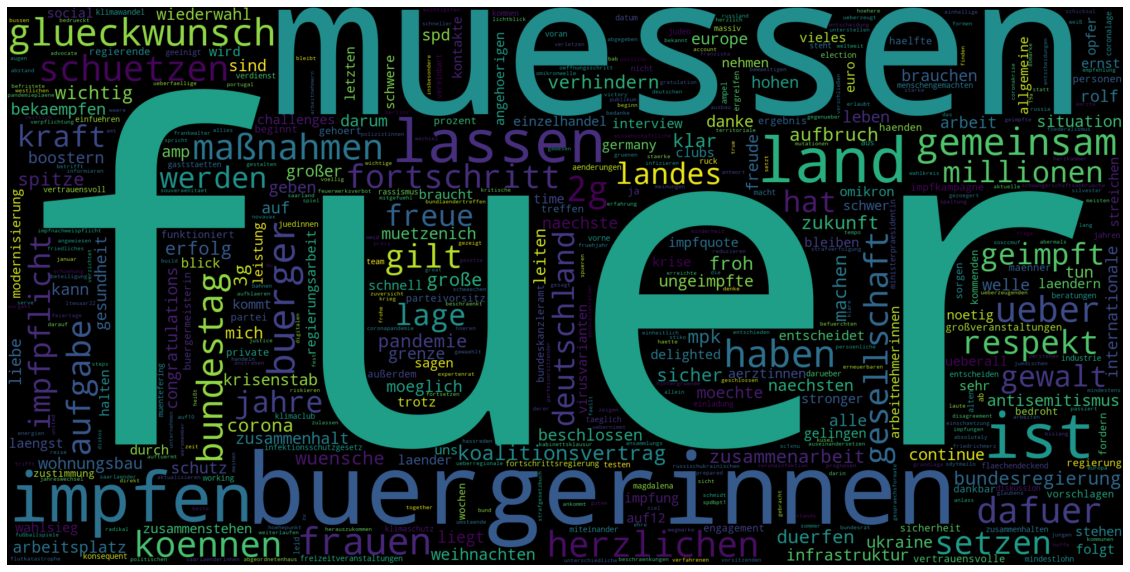

In [30]:
# Plot Word Cloud after cleaning
plt.figure(figsize = (20,20))
cleanedwords = ' '.join([txt for txt in cleansedTweetDFShort10copy['text']])
wordCloud = WordCloud(max_words = 500, width=2000, height = 1000, max_font_size = 1000, 
                      collocations=False).generate(cleanedwords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [31]:
# Sentiment Analysis with TextBlob 

# Create a function to compute analysis

def getA(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

cleansedTweetDFShort10['Analysis'] = cleansedTweetDFShort10['Sentiment (Polarity)'].apply(getA)
cleansedTweetDFShort10

,tweetid,date,time,user,text,Personal Opinion (Subjectivity),Sentiment (Polarity),Analysis
12,1508125473842335749,2022-03-27,16:55:07,38150247,Die Saarlaenderinnen und Saarlaender haben sic...,0.000000,0.675000,positive
21,1504398354565976070,2022-03-17,10:04:52,38150247,Meine persoenliche Position ist laengst bekann...,0.000000,0.175000,positive
54,1492872048120668161,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",0.000000,0.333333,positive
55,1492074452796022791,2022-02-11,09:54:05,38150247,Fuer die aktuelle Welle der Pandemie gibt es A...,0.000000,0.500000,positive
56,1492074451432873985,2022-02-11,09:54:05,38150247,Die Corona-Pandemie und auch die Flutkatastrop...,0.000000,0.350000,positive
...,...,...,...,...,...,...,...,...
169,1456191852026159105,2021-11-04,09:29:26,38150247,Heute jaehrt sich das Auffliegen des rechtsext...,0.000000,-0.037500,negative
172,1454008788638474240,2021-10-29,08:54:44,38150247,"Lieber Norbert, vielen Dank fuer das große Eng...",0.250000,0.175000,positive
174,1453697312149151747,2021-10-28,12:17:02,38150247,In der Bundesregierung und auch auf anderen Eb...,0.250000,0.000000,neutral
176,1453279700990763012,2021-10-27,08:37:36,38150247,"Vielen Dank fuer die Einladung zum Kongress, u...",0.333333,0.333333,positive


In [32]:
# Dataframe for Visualization

sortedDf = cleansedTweetDFShort10.sort_values(by=['Sentiment (Polarity)'])

sortedDf = sortedDf.astype({'Analysis':'string'})
print(sortedDf.dtypes)
sortedDf.reset_index(inplace=True, drop=True) # Reset index
sortedDf.head()

tweetid                             object
date                                object
time                                object
user                                object
text                                string
Personal Opinion (Subjectivity)    float64
Sentiment (Polarity)               float64
Analysis                            string
dtype: object


,tweetid,date,time,user,text,Personal Opinion (Subjectivity),Sentiment (Polarity),Analysis
0,1458712837417807873,2021-11-11,08:26:56,38150247,Die Corona-Lage ist besorgniserregend - was wi...,0.0,-1.000000,negative
1,1458004091834179586,2021-11-09,09:30:38,38150247,Das heutige Datum sollte uns mahnen und Mut ma...,0.0,-0.500000,negative
2,1485520128980701187,2022-01-24,07:49:33,38150247,"Wer sich entscheidet, sich nicht impfen zu las...",0.0,-0.466667,negative
3,1466133588856946695,2021-12-01,19:54:21,38150247,"Helft uns allen, vermeidbares Leid zu verhinde...",0.0,-0.333333,negative
4,1490374584448733191,2022-02-06,17:19:25,38150247,Die Staerke der westlichen Antwort auf die Lag...,0.0,-0.333333,negative


In [33]:
# Show texts with Polarity and Analysis 

# Problem erkannt: Er schreibt sowohl englisch als auch deutsch

sortedDf

for i in range (0, sortedDf.shape[0]):
    print(sortedDf['text'][i])
    print(sortedDf['Personal Opinion (Subjectivity)'][i])
    print(sortedDf['Sentiment (Polarity)'][i])
    print(sortedDf['Analysis'][i])
    print()

Die Corona-Lage ist besorgniserregend - was wir tun und an gesetzlichen Aenderungen heute einbringen, dazu spreche ich gleich im Bundestag👇 
0.0
-1.0
negative

Das heutige Datum sollte uns mahnen und Mut machen: Wir muessen gegen Judenhass und Rassismus aufstehen und fuer den Zusammenhalt und den Respekt in der Gesellschaft kaempfen. NieWieder
0.0
-0.5
negative

Wer sich entscheidet, sich nicht impfen zu lassen, trifft die Entscheidung nicht fuer sich allein. Er entscheidet mit ueber das Schicksal all derer, die sich deshalb infizieren. Mein Interview zu Corona, einer Impfpflicht und der Situation in der Ukraine: 
0.0
-0.4666666666666666
negative

Helft uns allen, vermeidbares Leid zu verhindern. Lasst euch impfen, schuetzt euer Leben und das der anderen. JKLive 
0.0
-0.3333333333333333
negative

Die Staerke der westlichen Antwort auf die Lage an der russisch-ukrainischen Grenze liegt darin, dass wir voellig einheitlich handeln. Denn jetzt geht es darum, Krieg in Europa zu verhindern. 

In [34]:
# Print Positive tweets

j=1;

for i in range(0, sortedDf.shape[0]):
    if(sortedDf['Analysis'][i] == 'positive'):
        print(str(j) + ') ' + sortedDf['text'][i])
        print(sortedDf['Personal Opinion (Subjectivity)'][i])
        print(sortedDf['Sentiment (Polarity)'][i])
        print(sortedDf['Analysis'][i])
        print()
        j=j+1

1) Abermals heißt es zu Weihnachten: Kontakte reduzieren. Ich weiß, das faellt gerade jetzt besonders schwer. Aber wenn wir zusammenstehen und uns impfen lassen, kommen wir durch diese Krise. Ich wuensche uns allen trotz dieser Umstaende ein friedliches Fest und frohe Weihnachten!
0.0
0.037500000000000006
positive

2) Ich bin froh, dass in dieser schwierigen Lage der Schulterschluss funktioniert, dass die Parteipolitik in den Hintergrund und das Wohl der Buergerinnen und Buerger in den Vordergrund rueckt. Jetzt ist die Zeit fuer Solidaritaet. (4/4)
0.0
0.05000000000000001
positive

3) Was jetzt wichtig ist: Dass wir noch viele ueberzeugen, sich impfen zu lassen. Wir sehen auf den Intensivstationen: Es reicht nicht. Es muessen sich mehr Buergerinnen und Buerger schuetzen. Wir muessen millionenfach boostern, viel mehr testen und 2G-Regeln nutzen.
0.625
0.0875
positive

4) Die Ampel steht. Wir haben uns auf einen Koalitionsvertrag geeinigt. Wir wollen uns etwas zutrauen und mehr Fortschri

In [35]:
# Print Negative tweets

j=1;

for i in range(0, sortedDf.shape[0]):
    if(sortedDf['Analysis'][i] == 'negative'):
        print(str(j) + ') ' + sortedDf['text'][i])
        print(sortedDf['Personal Opinion (Subjectivity)'][i])
        print(sortedDf['Sentiment (Polarity)'][i])
        print(sortedDf['Analysis'][i])
        print()
        j=j+1

1) Die Corona-Lage ist besorgniserregend - was wir tun und an gesetzlichen Aenderungen heute einbringen, dazu spreche ich gleich im Bundestag👇 
0.0
-1.0
negative

2) Das heutige Datum sollte uns mahnen und Mut machen: Wir muessen gegen Judenhass und Rassismus aufstehen und fuer den Zusammenhalt und den Respekt in der Gesellschaft kaempfen. NieWieder
0.0
-0.5
negative

3) Wer sich entscheidet, sich nicht impfen zu lassen, trifft die Entscheidung nicht fuer sich allein. Er entscheidet mit ueber das Schicksal all derer, die sich deshalb infizieren. Mein Interview zu Corona, einer Impfpflicht und der Situation in der Ukraine: 
0.0
-0.4666666666666666
negative

4) Helft uns allen, vermeidbares Leid zu verhindern. Lasst euch impfen, schuetzt euer Leben und das der anderen. JKLive 
0.0
-0.3333333333333333
negative

5) Die Staerke der westlichen Antwort auf die Lage an der russisch-ukrainischen Grenze liegt darin, dass wir voellig einheitlich handeln. Denn jetzt geht es darum, Krieg in Europa 

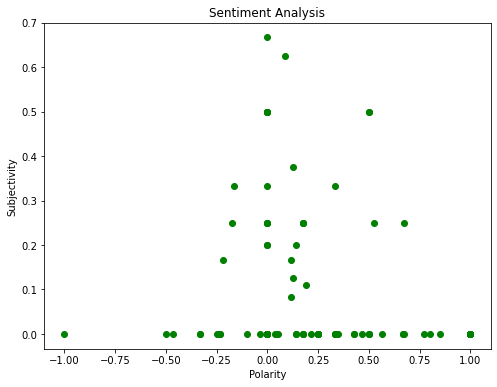

In [36]:
#Plot polarity and subjectivity

plt.figure(figsize=(8,6))

for i in range (0, sortedDf.shape[0]):
    plt.scatter(sortedDf['Sentiment (Polarity)'][i], sortedDf['Personal Opinion (Subjectivity)'][i], color='Green')
                
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [37]:
# Get the percentage of positive tweets

ptweets = sortedDf[sortedDf.Analysis =="positive"] 

print("Positive Tweets in percent: "+str(round((ptweets.shape[0]/sortedDf.shape[0])*100, 1)) + '%')

Positive Tweets in percent: 51.0%


In [38]:
# Get the negative of positive tweets

neutweets = sortedDf[sortedDf.Analysis =="neutral"] 

print("Neutral Tweets in percent: "+str(round((neutweets.shape[0]/sortedDf.shape[0])*100, 1)) + '%')

Neutral Tweets in percent: 36.0%


In [39]:
# Get the negative of positive tweets

ntweets = sortedDf[sortedDf.Analysis =="negative"] 

print("Negative Tweets in percent: "+str(round((ntweets.shape[0]/sortedDf.shape[0])*100, 1)) + '%')

Negative Tweets in percent: 13.0%


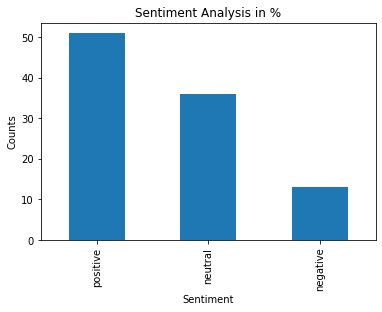

In [40]:
# Show Analysis

sortedDf['Analysis'].value_counts()

plt.title('Sentiment Analysis in %')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
sortedDf['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [41]:
# To avoid repetitions in our code, here are some plotting functions which will be used often

def plot_sentiment_period(df, info):
    
    # Using the mean values of sentiment for each period
    df1 = df.groupby(df['datetime'].dt.to_period(info['period'])).mean()

    df1.reset_index(inplace=True)
    df1['datetime'] = pd.PeriodIndex(df1['datetime']).to_timestamp()
    plot_df = pd.DataFrame(df1, df1.index, info['cols'])

    plt.figure(figsize=(15, 10))
    ax = sns.lineplot(data=plot_df, linewidth = 3, dashes = False)
    plt.legend(loc='best', fontsize=15)
    plt.title(info['title'], fontsize=20)
    plt.xlabel(info['xlab'], fontsize=15)
    plt.ylabel(info['ylab'], fontsize=15)
    plt.tight_layout()
    #plt.savefig('images/' + info['fname'])    
    return


def plot_fractions(props, title, fname):
    
    plt1 = props.plot(kind='bar', stacked=False, figsize=(16,5), colormap='Spectral') 
    plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Online storm', fontweight='bold', fontsize=18)
    plt.xticks(rotation=0,fontsize=14)
    #plt.ylim(0, 0.5)
    plt.ylabel('Fraction of Tweets', fontweight='bold', fontsize=18)
    plt1.set_title(label=title, fontweight='bold', size=20)
    plt.tight_layout()
    plt.savefig('images/' + fname + '.png')
    
    return


def plot_frequency_chart(info):
    
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.set_context("notebook", font_scale=1)    
    ax = sns.barplot(x=info['x'], y=info['y'], data=info['data'], palette=(info['pal']))
    ax.set_title(label=info['title'], fontweight='bold', size=18)
    plt.ylabel(info['ylab'], fontsize=16)
    plt.xlabel(info['xlab'], fontsize=16)
    plt.xticks(rotation=info['angle'],fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    #plt.savefig('images/' + info['fname'])
    
    return

In [42]:
# Sorting after values descending

cleansedTweetDFShort10
print(cleansedTweetDFShort10.sort_values("date",ascending = False).head())

                tweetid        date      time      user  \
12  1508125473842335749  2022-03-27  16:55:07  38150247   
21  1504398354565976070  2022-03-17  10:04:52  38150247   
54  1492872048120668161  2022-02-13  14:43:27  38150247   
55  1492074452796022791  2022-02-11  09:54:05  38150247   
56  1492074451432873985  2022-02-11  09:54:05  38150247   

                                                 text  \
12  Die Saarlaenderinnen und Saarlaender haben sic...   
21  Meine persoenliche Position ist laengst bekann...   
54  Ich freue mich, wenn Sie und Ihr mir ab heute ...   
55  Fuer die aktuelle Welle der Pandemie gibt es A...   
56  Die Corona-Pandemie und auch die Flutkatastrop...   

    Personal Opinion (Subjectivity)  Sentiment (Polarity)  Analysis  
12                              0.0              0.675000  positive  
21                              0.0              0.175000  positive  
54                              0.0              0.333333  positive  
55                    

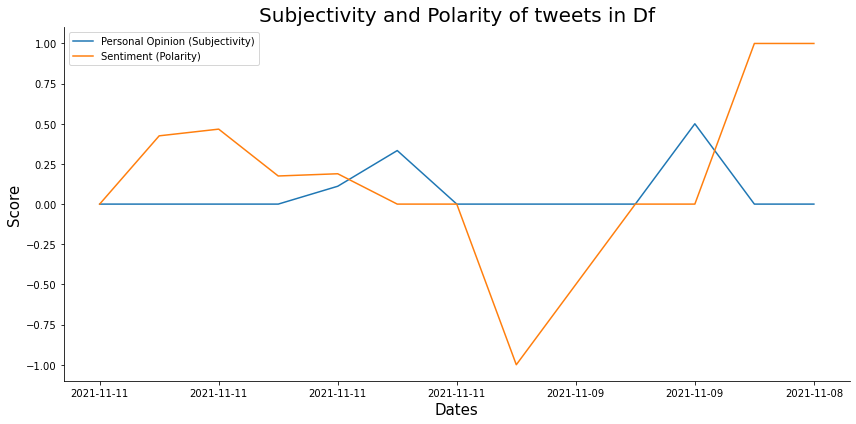

,tweetid,time,user,text,Personal Opinion (Subjectivity),Sentiment (Polarity),Analysis
date,,,,,,,
2021-11-11,1458819994024919041,15:32:44,38150247,Die Bilder von der polnischen Grenze sind ersc...,0.000000,0.000000,neutral
2021-11-11,1458812993295237125,15:04:55,38150247,"Wir sind finanzpolitisch auf Kurs, es geht wei...",0.000000,0.425000,positive
2021-11-11,1458725565020753926,09:17:31,38150247,"Wir haben genug Impfstoff, aber keineswegs all...",0.000000,0.466667,positive
2021-11-11,1458725563305238531,09:17:30,38150247,Wir haben mit Arbeitnehmer*innen und Arbeitgeb...,0.000000,0.175000,positive
2021-11-11,1458725561593958400,09:17:30,38150247,Die Aenderungen im Infektionsschutzgesetz gebe...,0.111111,0.188889,positive
2021-11-11,1458725559987548161,09:17:29,38150247,"Wir muessen die Impfzentren wiedereroeffnen, a...",0.333333,0.000000,neutral
2021-11-11,1458725558716715018,09:17:29,38150247,Wir muessen unser Land winterfest machen. Das ...,0.000000,0.000000,neutral
2021-11-11,1458712837417807873,08:26:56,38150247,Die Corona-Lage ist besorgniserregend - was wi...,0.000000,-1.000000,negative
2021-11-09,1458004091834179586,09:30:38,38150247,Das heutige Datum sollte uns mahnen und Mut ma...,0.000000,-0.500000,negative


In [43]:
sortedDfdiagram = cleansedTweetDFShort10.copy()
# filter for these dates
sortedDfdiagram.set_index('date',inplace=True)
sortedDfdiagram=sortedDfdiagram[(sortedDfdiagram.index<='2021-11-11') & (sortedDfdiagram.index>='2021-11-08')]
sortedDfdiagram.plot(figsize=(12,6));
plt.ylabel('Score', fontsize=15)
plt.xlabel('Dates', fontsize=15)
plt.legend().set_visible(True)
plt.title('Subjectivity and Polarity of tweets in Df', fontsize=20)
plt.tight_layout()
sns.despine(top=True)  
plt.show()
sortedDfdiagram

In [44]:
# Word frequency

# We need these imports for the wordcloud representation:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from matplotlib.colors import makeMappingArray
#from palettable.colorbrewer.diverging import Spectral_4

In [45]:
from collections import Counter    # Counts the most common items in a list

In [46]:
def join_edited_string(edited_tweets):
    
    edited_string = ''
    for row in edited_tweets:
        edited_string = edited_string + ' ' + row
        
    return edited_string

def get_trigrams(trigrams, top_grams):
    
    grams_str = []
    data = []

    gram_counter = Counter(trigrams)
    
    for grams in gram_counter.most_common(10):
        gram = ''
        grams_str = grams[0]
        grams_str_count = []
        for n in range(0,3):
            gram = gram + grams_str[n] + ' '
        grams_str_count.append(gram)
        grams_str_count.append(grams[1])
        data.append(grams_str_count)
        print(grams_str_count)

    df = pd.DataFrame(data, columns = ['Grams', 'Count'])

    return df

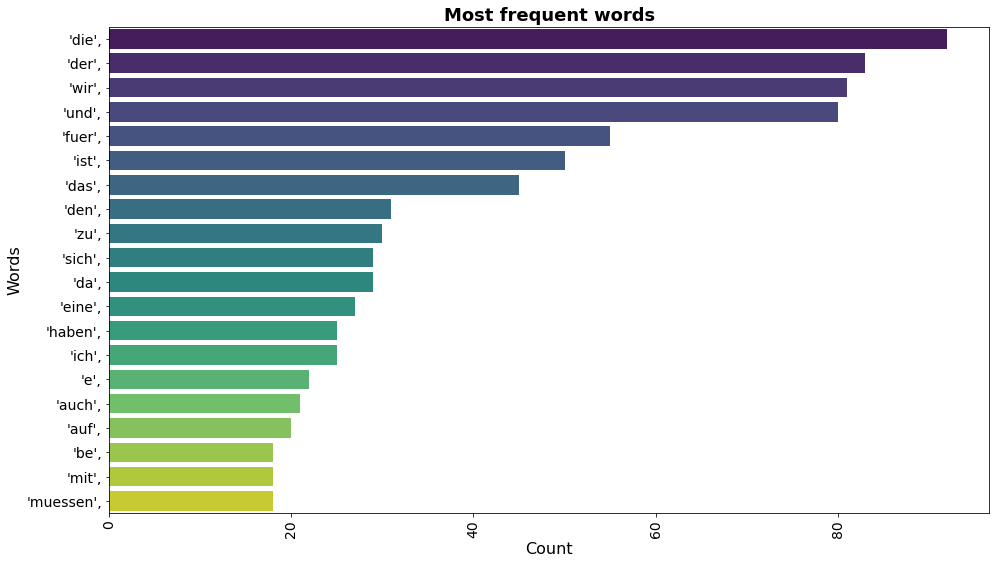

In [47]:
# Join all the edited tweets in one single string
joined_string = join_edited_string(cleansedTweetDFShort10copy['edited'])

# Get tokens
tokens = joined_string.split(' ')

# get trigrams
trigrams = nltk.trigrams(tokens)

# plot word frequency during online storm
word_counter = Counter(tokens)
df_counter = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
info = {'data': df_counter, 'x': 'freq', 'y': 'word',
       'xlab': 'Count', 'ylab': 'Words', 'pal':'viridis',
       'title': 'Most frequent words',
       'fname':'word_frequency_before_onlinestorm.png',
       'angle': 90}
plot_frequency_chart(info)

["'buerger', '*', 'innen', ", 4]
["'ich', 'freue', 'mich', ", 4]
["'fuer', 'unser', 'land', ", 4]
["'bin', 'froh', 'das', ", 4]
["'duerfen', 'wir', 'nicht', ", 3]
["'buergerinnen', 'und', 'buerger', ", 3]
["'bi', 'ende', 'des', ", 3]
["'ende', 'des', 'jahres', ", 3]
["'glueckwunsch', 'zur', 'wiederwahl', ", 3]
["'ich', 'bin', 'sicher', ", 2]


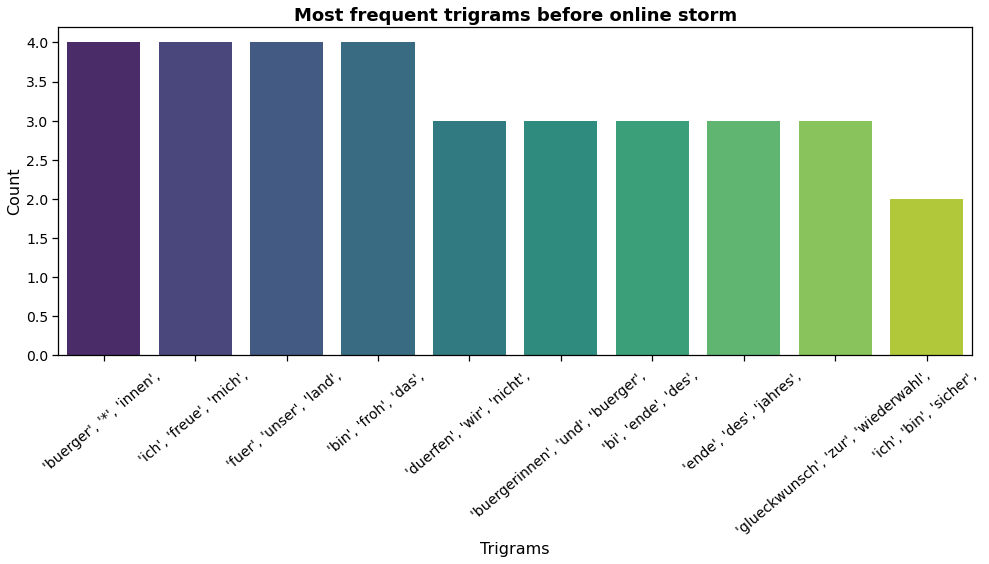

In [48]:
# plot trigram frequency
df_trigrams = get_trigrams(trigrams, 10)
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': 'Trigrams', 'ylab': 'Count', 'pal':'viridis',
       'title': 'Most frequent trigrams before online storm',
       'fname':'trigrams_frequency_before_onlinestorm.png',
       'angle': 40}
plot_frequency_chart(info)

In [49]:
# LDATopics extraction
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_top_n_words(n, n_topics, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:, index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            try:
                topic_words.append(the_word.encode('ascii').decode('utf-8'))
            except:
                pass
        top_words.append(", ".join(topic_words))         
    return top_words

In [50]:
# LDA topics
def get_topics(edited, n_topics, n_words):

    eds = edited.values
    
    vec = TfidfVectorizer(use_idf=True, smooth_idf=True)
    document_term_matrix = vec.fit_transform(eds)
    
    model = LatentDirichletAllocation(n_components=n_topics)
    topic_matrix = model.fit_transform(document_term_matrix)
    
    keys = get_keys(topic_matrix)
    categories, counts = keys_to_counts(keys)
    top_n_words = get_top_n_words(n_words, n_topics, keys, document_term_matrix, vec)

    topics = ['Topic {}: \n'.format(i + 1) + top_n_words[i] for i in categories]
    data=[]
    for i, topic in enumerate(topics):
        tmp = []
        tmp.append(topic)
        tmp.append(counts[i])
        data.append(tmp)
    df_topics = pd.DataFrame(data, columns = ['Topics', 'Count'])
    
    return df_topics

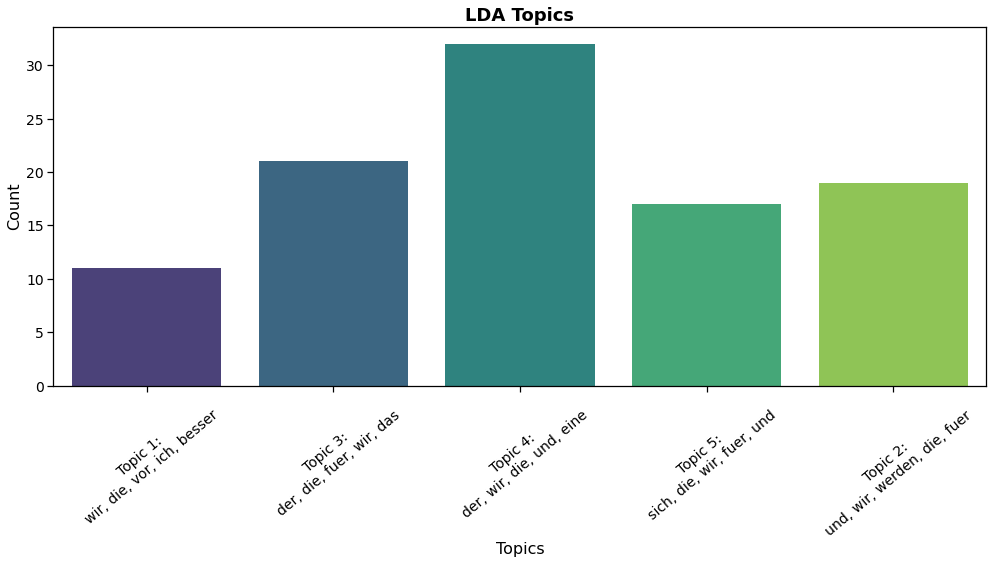

In [51]:
# Filtering the tweets of the 6 years before the online storm


# LDA topics
df_topics = get_topics(cleansedTweetDFShort10copy['edited'], 5, 5)
info = {'data': df_topics, 'x': 'Topics', 'y': 'Count',
       'xlab': 'Topics', 'ylab': 'Count', 'pal':'viridis',
       'title': 'LDA Topics',
       'fname':'LDA_Topics.png',
       'angle': 40}
plot_frequency_chart(info)

In [52]:
# Sentiment and Emotion Analysis

warnings.filterwarnings("ignore", category=DeprecationWarning)

emotionDF = cleansedTweetDFShort10copy.copy()

In [53]:
#Translate word using Google translator for Emotionanalysis

#import googletrans
#from googletrans import Translator

#translater = Translator() #German: 'de'

#print(googletrans.LANGUAGES) 

#Test
#translator = Translator()
#translation = translator.translate("Der Himmel ist blau und ich mag Bananen", dest='en')
#print(translation.text)

In [54]:
# Tryed to translate each tweets which was no good idea

#emotiontest = emotionDF[:3].copy()
#emotiontest['edited'] = emotiontest['edited'].astype(str)
#emotiontest['translated'] = emotiontest['edited'].apply(translater.translate, src ="de", dest='en').apply(getattr, args=('text',))
#emotiontest
# Problem: Number of translations is limited

# Translate the english row into german with google did not work

#ncr10 = ncr[:100].copy()
#ncr10.info()
#ncr10['Deutsch'] = ncr10['English'].apply(translater.translate, src ="en", dest='de').apply(getattr, args=('text',))
#ncr10['Deutsch']
#ncr10

In [55]:
# Emotionanalysis

#import termcolor
#import sys
#from termcolor import colored, cprint

# Importing the data from the NCR lexicon
#ncr = pd.read_csv('NCR-lexicon.csv', sep =';')
#ncr = ncr.astype({'English':'string'})
#ncr

In [56]:
# AB HIER PHILIP

# Translate the english row into german by using the Google Translator for translation

# Importing the data from the NCR lexicon
lexicon = pd.read_csv('NCR-lexicon-german-cleaned.csv', header= 0,
                        encoding= 'unicode_escape', sep =';')
# Drop last columns
lexicon = lexicon.iloc[: 10, :12]
lexicon

,English,cleanedEnglish,Positiv,Negativ,Wut,Vorwegnahme,Der Ekel,Furcht,Freude,Traurigkeit,berraschung,Vertrauen
0,verblfft,verbluefft,0,0,0,0,0,0,0,0,0,0
1,Abakus,Abakus,0,0,0,0,0,0,0,0,0,1
2,aufgeben,aufgeben,0,1,0,0,0,1,0,1,0,0
3,verlassen,verlassen,0,1,1,0,0,1,0,1,0,0
4,Aufgabe,Aufgabe,0,1,1,0,0,1,0,1,1,0
5,nachlassen,nachlassen,0,0,0,0,0,0,0,0,0,0
6,Minderung,Minderung,0,0,0,0,0,0,0,0,0,0
7,Abb,Abb,1,0,0,0,0,0,0,0,0,0
8,Abt,Abt,0,0,0,0,0,0,0,0,0,1
9,abkrzen,abkuerzen,0,0,0,0,0,0,0,0,0,0


In [57]:
emotionDf100 = emotionDF[:100].copy()

# Let's create a list of the emotions
emotions = ['Anger', 'Anticipation','Disgust','Fear', 'Joy','Sadness', 'Surprise', 'Trust']

def join_edited_string(edited_tweets):
    
    edited_string = ''
    for row in edited_tweets:
        edited_string = edited_string + ' ' + row
        
    return edited_string

# Join all the edited tweets in one single string
joined_string = join_edited_string(emotionDf100['edited'])

# Get tokens
tokens = joined_string.split(' ')

In [58]:
unique_words = set(tokens)

word_to_ind = dict((word, i) for i, word in enumerate(unique_words))
ind_to_word = dict((i, word) for i, word in enumerate(unique_words))

In [59]:
def plot_emotions_period(df, cols, title, fname, period = 'h' ):

    df1 = emotionDf100.groupby(emotionDf100['date'].dt.to_period(period)).mean()

    df1.reset_index(inplace=True)
    df1['datetime'] = pd.PeriodIndex(df1['datetime']).to_timestamp()
    plot_df = pd.DataFrame(df1, df1.index, cols)

    plt.figure(figsize=(15, 10))
    ax = sns.lineplot(data=plot_df, linewidth = 3,dashes = False)
    plt.legend(loc='best', fontsize=15)
    plt.title(title, fontsize=20)
    plt.xlabel('Time (hours)', fontsize=15)
    plt.ylabel('Z-scored Emotions', fontsize=15)
    plt.savefig('images/'+ fname  + '.png')       
    
    return

In [95]:
def get_tweet_emotions(df, emotions, col):

    df_tweets = emotionDf100.copy()
    #df_tweets.drop(['sentiment','sentiment_intensity'], axis=1, inplace=True)
    
    emo_info = {'emotion':'' , 'emo_frq': defaultdict(int) }    

    list_emotion_counts = []

    # creating a dictionary list to hold the frequency of the words
    # contributing to the emotions
    for emotion in emotions:
        emo_info = {}
        emo_info['emotion'] = emotion
        emo_info['emo_frq'] = defaultdict(int)
        list_emotion_counts.append(emo_info)
    
    # bulding a zeros matrix to hold the emotions data
    df_emotions = pd.DataFrame(0, index=emotionDf100.index, columns=emotions)

    # stemming the word to facilitate the search in NRC
    stemmer = SnowballStemmer("german")
    
    # iterating in the tweets data set
    for i, row in df_tweets.iterrows(): # for each tweet ...
        tweet = word_tokenize(df_tweets.loc[i][col])
        for word in tweet: # for each word ...
            word_stemmed = stemmer.stem(word.lower())
            # check if the word is in NRC
            result = lexicon[lexicon.English == word_stemmed]
            # we have a match
            if not result.empty:
                # update the tweet-emotions counts
                for idx, emotion in enumerate(emotions):
                    df_emotions.at[i, emotion] += result[emotion]
                    
                    # update the frequencies dictionary list
                    if result[emotion].any():
                        try:
                            list_emotion_counts[idx]['emo_frq'][word_to_ind[word]] += 1
                        except:
                            #print("get_tweet_emotions - Exception")
                            continue
    
    # append the emotions matrix to the tweets data set
    df_tweets = pd.concat([df_tweets, df_emotions], axis=1)

    return df_tweets, list_emotion_counts

In [61]:
# Create a list of words to highlight 
def get_words(word_list, emotions):
    
    words_emotion_idx = []
    
    for i, word in enumerate(word_list):
        word = stemmer.stem(word.lower())
        result = lexicon[lexicon.English == word]
        if not result.empty:
            for emotion in emotions:
                if result[emotion].any() > 0:
                    words_emotion_idx.append(i)
                
    return words_emotion_idx

In [62]:
def get_top_emotion_words(word_counts, n = 5):

    # Here I map the numpy array "words" with the index and word frequency
    words = np.zeros((len(word_counts), 2), dtype=int)
    for i, w in enumerate(word_counts):
        words[i][0] = w
        words[i][1] = word_counts[w]

    # From the indexes generated by the argsort function, 
    # I get the order of the top n words in the list
    top_words_idx = np.flip(np.argsort(words[:,1])[-n:],0)

    # The resulting indexes are now used as keys in the dic to get the words
    top_words = [words[ind][0] for ind in top_words_idx]
        
    return words, top_words, top_words_idx

In [65]:
# This is now the function to display and highlight 
# the words associated to specific emotions
def print_colored_emotions(tweets, emotions, color, on_color):
    
    for tweet in tweets:

        word_list = word_tokenize(tweet)

        word_emotion_idx = get_words(word_list, emotions)

        for i, w in enumerate(word_list):
            if i in word_emotion_idx:
                w=colored(w, color=color, on_color=on_color)
            print(w, end='') 
            print(' ', end='')  

        print('\n')

        
    return

In [66]:
emotionDf100.head()

,tweetid,date,time,user,text,Personal Opinion (Subjectivity),Sentiment (Polarity),edited,word_count
12,1508125473842335749,2022-03-27,16:55:07,38150247,saarlaenderinnen saarlaender klar fuer wechsel...,0.0,0.675000,"['die', 'saarlaenderinnen', 'saarlaender', 'ha...",17
21,1504398354565976070,2022-03-17,10:04:52,38150247,persoenliche position laengst bekannt fuer zei...,0.0,0.175000,"['meine', 'persoenliche', 'position', 'ist', '...",21
54,1492872048120668161,2022-02-13,14:43:27,38150247,freue mich folgt fuer alles regierungsarbeit ...,0.0,0.333333,"['ich', 'freue', 'mich', 'sie', 'und', 'ihr', ...",14
55,1492074452796022791,2022-02-11,09:54:05,38150247,fuer aktuelle welle pandemie anlass zuversicht...,0.0,0.500000,"['fuer', 'die', 'aktuelle', 'welle', 'der', 'p...",22
56,1492074451432873985,2022-02-11,09:54:05,38150247,coronapandemie flutkatastrophe sommer gezeigt ...,0.0,0.350000,"['die', 'corona-pandemie', 'auch', 'die', 'flu...",17


In [96]:
# Conncting words to emotions
# We are using the NCR lexicon to associate words to emotions 

df_emo, list_emotion_counts = get_tweet_emotions(emotionDf100, emotions, 'edited')

# Preparing for time series
df_emo['date']= pd.to_datetime(df_emo['date']) 

In [98]:
#print(help(list_emotion_counts[0]["emo_frq"]))
print(list_emotion_counts)

[{'emotion': 'Anger', 'emo_frq': defaultdict(<class 'int'>, {})}, {'emotion': 'Anticipation', 'emo_frq': defaultdict(<class 'int'>, {})}, {'emotion': 'Disgust', 'emo_frq': defaultdict(<class 'int'>, {})}, {'emotion': 'Fear', 'emo_frq': defaultdict(<class 'int'>, {})}, {'emotion': 'Joy', 'emo_frq': defaultdict(<class 'int'>, {})}, {'emotion': 'Sadness', 'emo_frq': defaultdict(<class 'int'>, {})}, {'emotion': 'Surprise', 'emo_frq': defaultdict(<class 'int'>, {})}, {'emotion': 'Trust', 'emo_frq': defaultdict(<class 'int'>, {})}]


dict_keys([])


ValueError: min() arg is an empty sequence

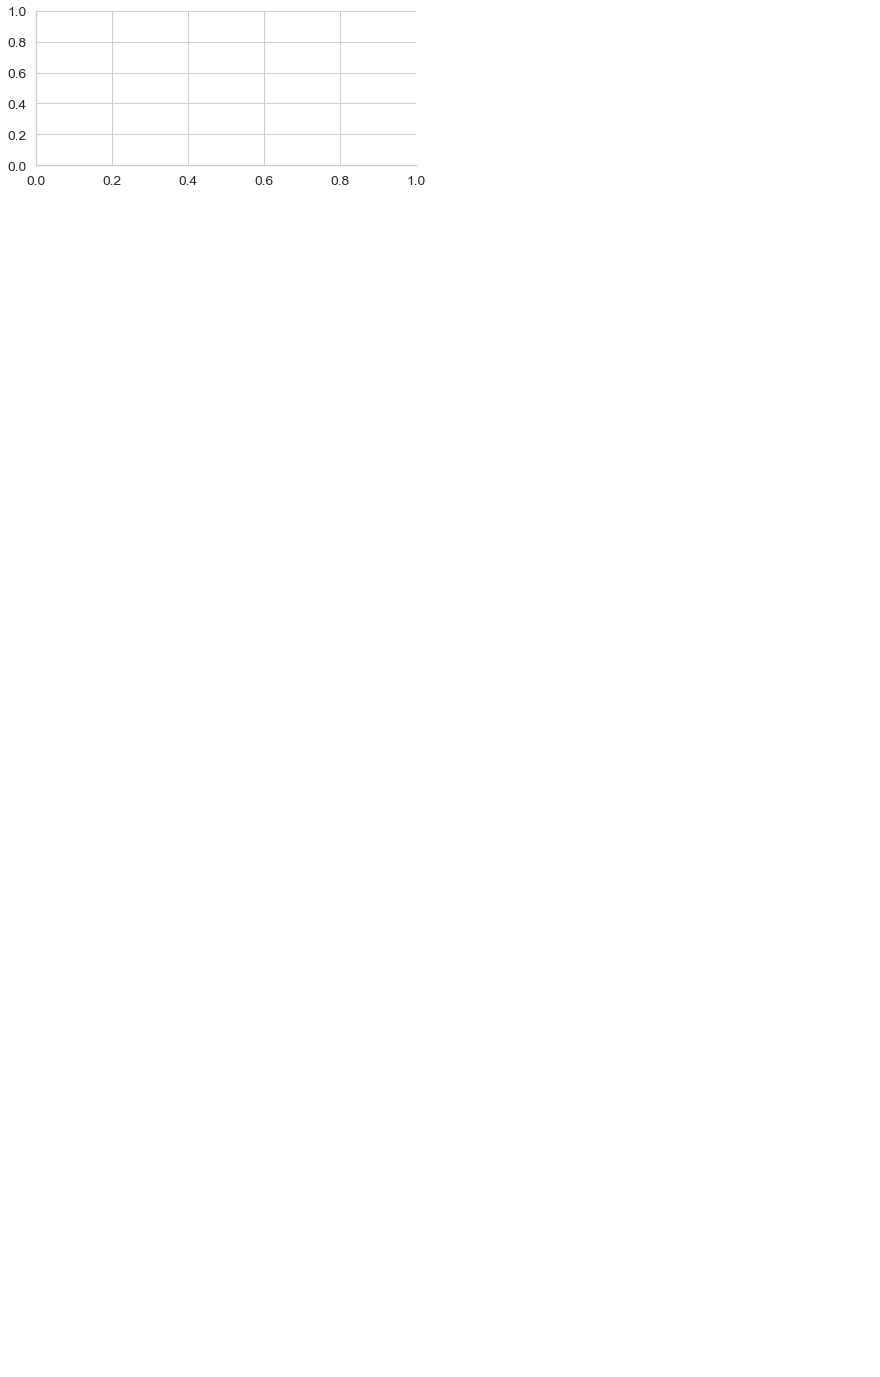

In [82]:
# Plotting the 10 words that contribute the most for each of the 8 emotions

fig, axs = plt.subplots(figsize=(15, 25), frameon=False) 
plt.box(False)
plt.axis('off')
plt.subplots_adjust(hspace = 1.6)
counter = 0

for i, emotion in enumerate(emotions): # for each emotioin

    # This is the dict that holds the top 10 words 
    
    words, top_words, top_words_indices = get_top_emotion_words(list_emotion_counts[i]['emo_frq'], 10)
    #print(str(list_emotion_counts)+"\n")
    #print(words)
    
    info = {'values' : [words[ind][1] for ind in top_words_indices], 
                      'labels' : [ind_to_word[word] for word in top_words]}
    #print(info)
    sns.set(style="whitegrid")
    sns.set_context("notebook", font_scale=1.25)
    ax = fig.add_subplot(4, 2, counter+1) # plot 2 charts in each of the 4 rows
    sns.despine()
    ax = sns.barplot(x='labels', y='values', data=info, palette=("cividis"))
    plt.ylabel('Top words', fontsize=12)
    ax.set_title(label=str('Emotion: ') + emotion, fontweight='bold', size=13)
    plt.xticks(rotation=45, fontsize=14)
    counter += 1

axs.set_title(label='\nTop 10 words for each emotion\n', 
             fontweight='bold', size=20, pad=40)
plt.tight_layout()
#plt.savefig('images/Top10_words_per_emotion.png')